In [1]:
import numpy as np
from rl_optimal_search.environment import target_env
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

In [114]:
class BasicPSAgent(object):
    """Projective Simulation agent with two-layered network. Features: forgetting, glow, reflection, optional softmax rule. """

    def __init__(self, num_actions, 
                 num_percepts_list, 
                 gamma_damping, 
                 eta_glow_damping, 
                 policy_type = 'standard', beta_softmax = 1, num_reflections = 0):
        
        """Initialize the basic PS agent. Arguments: 
            - num_actions: integer >=1, 
            - num_percepts_list: list of integers >=1, not nested, representing the cardinality of each category/feature of percept space.
            - gamma_damping: float between 0 and 1, controls forgetting/damping of h-values
            - eta_glow_damping: float between 0 and 1, controls the damping of glow; setting this to 1 effectively switches off glow
            - policy_type: string, 'standard' or 'softmax'; toggles the rule used to compute probabilities from h-values
            - beta_softmax: float >=0, probabilities are proportional to exp(beta*h_value). If policy_type != 'softmax', then this is irrelevant.
            - num_reflections: integer >=0 setting how many times the agent reflects, ie potentially goes back to the percept. Setting this to zero effectively deactivates reflection.
            -actions: list with the labels for each action.
            """
        self.num_actions = num_actions
        self.num_percepts_list = num_percepts_list
        self.gamma_damping = gamma_damping
        self.eta_glow_damping = eta_glow_damping
        self.policy_type = policy_type
        self.beta_softmax = beta_softmax
        self.num_reflections = num_reflections


        self.num_percepts = int(np.prod(np.array(self.num_percepts_list).astype(np.float64))) # total number of possible percepts

        self.h_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.float64) #Note: the first index specifies the action, the second index specifies the percept.
        self.g_matrix = np.zeros((self.num_actions, self.num_percepts), dtype=np.float64) #glow matrix, for processing delayed rewards

        if num_reflections > 0:
            self.last_percept_action = None  #stores the last realized percept-action pair for use with reflection. If reflection is deactivated, all necessary information is encoded in g_matrix.
            self.e_matrix = np.ones((self.num_actions, self.num_percepts), dtype=np.bool_) # emoticons
                #emoticons are initialized to True (happy, good choice) and set to false (sad, reflect again) only if the percept-action pair is used and does not yield a reward.

    def percept_preprocess(self, observation): # preparing for creating a percept
        """Takes a multi-feature percept and reduces it to a single integer index.
        Input: list of integers >=0, of the same length as self.num_percept_list; 
            respecting the cardinality specified by num_percepts_list: observation[i]<num_percepts_list[i] (strictly)
            Output: single integer."""
        percept = 0
        for which_feature in range(len(observation)):
            percept += int(observation[which_feature] * np.prod(self.num_percepts_list[:which_feature]))
        return percept
    
    def learn(self, observation, action, reward):
        # extract percept from observation
        percept = self.percept_preprocess(observation) 
        
        # Update glow matrix
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1
        
        # Update h matrix
        self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + self.g_matrix * reward
        
    def act(self, observation):
        # extract percept from observation
        percept = self.percept_preprocess(observation) 
        
        # sample action from policy
        return np.random.choice(self.num_actions, p=self.probability_distr(percept))
        

    def deliberate_and_learn(self, observation, reward):
        """Given an observation and a reward (from the previous interaction), this method
        updates the h_matrix, chooses the next action and records that choice in the g_matrix and last_percept_action.
        Arguments: 
            - observation: list of integers, as specified for percept_preprocess, 
            - reward: float
        Output: action, represented by a single integer index."""        
        self.h_matrix =  self.h_matrix - self.gamma_damping * (self.h_matrix - 1.) + self.g_matrix * reward # learning and forgetting
        #self.h_matrix=np.array([[0,0],[1,1]],dtype=np.float64)
        if (self.num_reflections > 0) and (self.last_percept_action != None) and (reward <= 0): # reflection update
            self.e_matrix[self.last_percept_action] = 0
        percept = self.percept_preprocess(observation) 
        action = np.random.choice(self.num_actions, p=self.probability_distr(percept)) #deliberate once
        for i_counter in range(self.num_reflections):  #if num_reflection >=1, repeat deliberation if indicated
            if self.e_matrix[action, percept]:
                break
            action = np.random.choice(self.actions, p=self.probability_distr(percept))		
        self.g_matrix = (1 - self.eta_glow_damping) * self.g_matrix
        self.g_matrix[action, percept] += 1#record latest decision in g_matrix
        if self.num_reflections > 0:
            self.last_percept_action = action, percept	#record latest decision in last_percept_action
        return action

    def probability_distr(self, percept):
        """Given a percept index, this method returns a probability distribution over actions
        (an array of length num_actions normalized to unit sum) computed according to policy_type."""        
        if self.policy_type == 'standard':
            h_vector = self.h_matrix[:, percept]
            probability_distr = h_vector / np.sum(h_vector)
        elif self.policy_type == 'softmax':
            h_vector = self.beta_softmax * self.h_matrix[:, percept]
            h_vector_mod = h_vector - np.max(h_vector)
            probability_distr = np.exp(h_vector_mod) / np.sum(np.exp(h_vector_mod))
        return probability_distr

    def erase_memory(self):
        self.h_matrix=np.ones((self.num_actions, self.num_percepts), dtype=np.float64)

In [228]:
num_state = 50
state_space = np.arange(num_state)
agent = BasicPSAgent(num_actions=2,
                  num_percepts_list= [num_state],
                  gamma_damping= 0.01,
                  eta_glow_damping = 0.01)
env = target_env(Nt = 20, L = 100, boundary_condition = 'periodic')
density = (env.Nt*2*np.pi)/env.L**2
density

0.012566370614359173

In [226]:
episodes = 1
time_ep = int(1e6)


time_to_reward = []
step_length = []
rew_step_length = []
pos_agent = np.zeros((episodes, time_ep, 2))
rewards = np.zeros((episodes, time_ep))

for e in (range(episodes)):
    
    env.init_env()
    direction = np.random.rand()*360
    current_step = 1
    
    pos_agent[e, 0, :] = env.agent_pos.clone()
    state = 1
    
    for t in tqdm(range(time_ep)):
        
        # sample action from policy
        action = agent.act([state])
        
        # if action is one, we change the direction of the agent
        if action == 1:
            direction = np.random.rand()*360 
        
        # do step
        env.step(direction)
        pos_agent[e, t, :] = env.agent_pos
        
        # check encounters and get reward
        reward = env.check_encounter()
        rewards[e, t] = reward
        
        # take info and learn
        agent.learn([state], action, reward)
        
        # update state with new info
        if action == 1 or reward == 1:
            direction = np.random.rand()*360
            current_state = 1 
            
            # Save info on step lengths
            if reward == 1:
                rew_step_length.append(current_step)
            else:
                step_length.append(current_step)
            # now update step length
            current_step = 1
        else:
            current_state += 1
            current_step += 1
            
        state = np.argwhere((state_space - current_state) <= 0)[-1]

  0%|          | 0/1000000 [00:00<?, ?it/s]

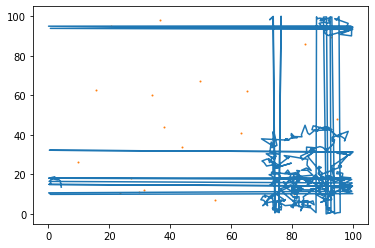

In [198]:
idx = 0
plt.plot(pos_agent[idx, -1000:, 0], pos_agent[idx, -1000:, 1])
plt.scatter(env.target_positions[:, 0], env.target_positions[:, 1], c = 'C1', s = 1)

### Low density ($\rho \approx 0.01$)

In [230]:
agent.h_matrix

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]])

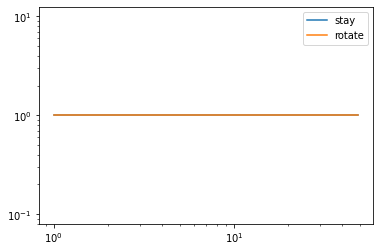

In [229]:
ifg, ax  = plt.subplots()
for h, lab in zip(agent.h_matrix, ['stay', 'rotate']):
    ax.loglog(np.arange(1, len(h)), h[1:], label = lab)
ax.legend()


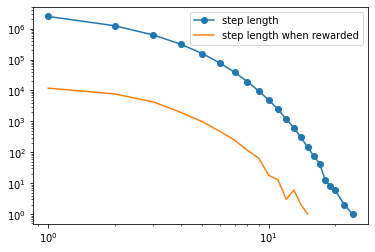

In [217]:
u, c = np.unique(step_length, return_counts = True)
plt.loglog(u, c, '-o', label = 'step length')

u, c = np.unique(rew_step_length, return_counts = True)
plt.loglog(u, c, '-', label = 'step length when rewarded')

plt.legend()

##### msd

In [219]:
T = 1000; N = 500

pos = np.zeros((N, T, 2))


for n in tqdm(range(N)):

    current_state = 1
    state = 1
    for t in (range(1, T)):
        pos[n, t, 0] = pos[n, t-1, 0] + np.cos(direction)
        pos[n, t, 1] = pos[n, t-1, 1] + np.sin(direction)

        action = agent.act([state])

        # if action is one, we change the direction of the agent
        if action == 1:
            direction = np.random.rand()*360 
            current_state = 1
        else:
            current_state += 1

        state = np.argwhere((state_space - current_state) <= 0)[-1]

  0%|          | 0/500 [00:00<?, ?it/s]

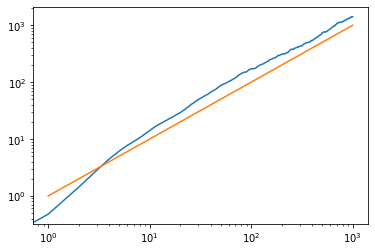

In [222]:
msd = (pos[:,:,0]**2).mean(0)
plt.loglog(msd)
plt.loglog(np.arange(1, T), np.arange(1, T))

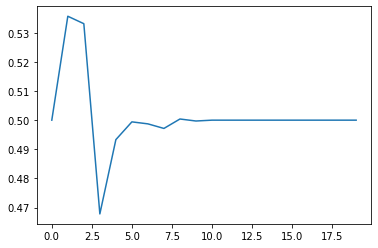

In [221]:
prob_s = agent.h_matrix[0,:]/agent.h_matrix.sum(0)
plt.plot(prob_s[:20])

### High density ($\rho \approx 0.3$)

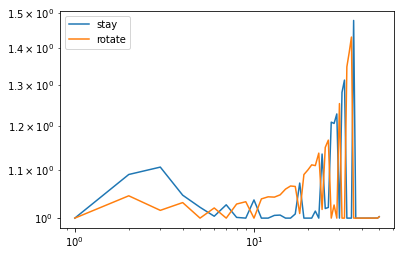

In [165]:
ifg, ax  = plt.subplots()
for h, lab in zip(agent.h_matrix, ['stay', 'rotate']):
    ax.loglog(np.arange(1, len(h)+1), h, label = lab)
ax.legend()


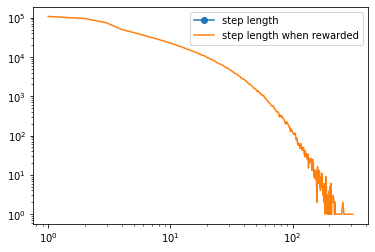

In [166]:
u, c = np.unique(step_length, return_counts = True)
plt.loglog(u, c, '-o', label = 'step length')

u, c = np.unique(rew_step_length, return_counts = True)
plt.loglog(u, c, '-', label = 'step length when rewarded')

plt.legend()

##### msd

In [171]:
T = 1000; N = 500

pos = np.zeros((N, T, 2))


for n in tqdm(range(N)):

    current_state = 1
    state = 1
    for t in (range(1, T)):
        pos[n, t, 0] = pos[n, t-1, 0] + np.cos(direction)
        pos[n, t, 1] = pos[n, t-1, 1] + np.sin(direction)

        action = agent.act([state])

        # if action is one, we change the direction of the agent
        if action == 1:
            direction = np.random.rand()*360 
            current_state = 1
        else:
            current_state += 1

        state = np.argwhere((state_space - current_state) <= 0)[-1]

  0%|          | 0/500 [00:00<?, ?it/s]

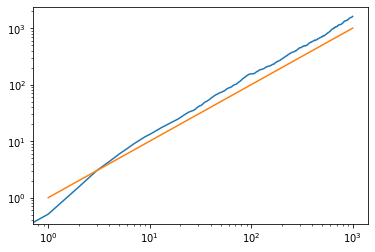

In [174]:
msd = (pos[:,:,0]**2).mean(0)
plt.loglog(msd)
plt.loglog(np.arange(1, T), np.arange(1, T))

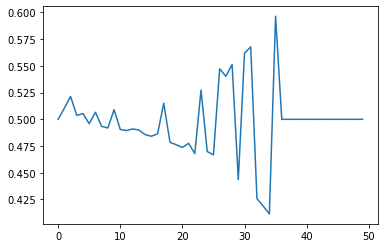

In [180]:
prob_s = agent.h_matrix[0,:]/agent.h_matrix.sum(0)
plt.plot(prob_s)